In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Calibrate the Camera
===


In [2]:
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/c*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

Correct for Image Distortion
====

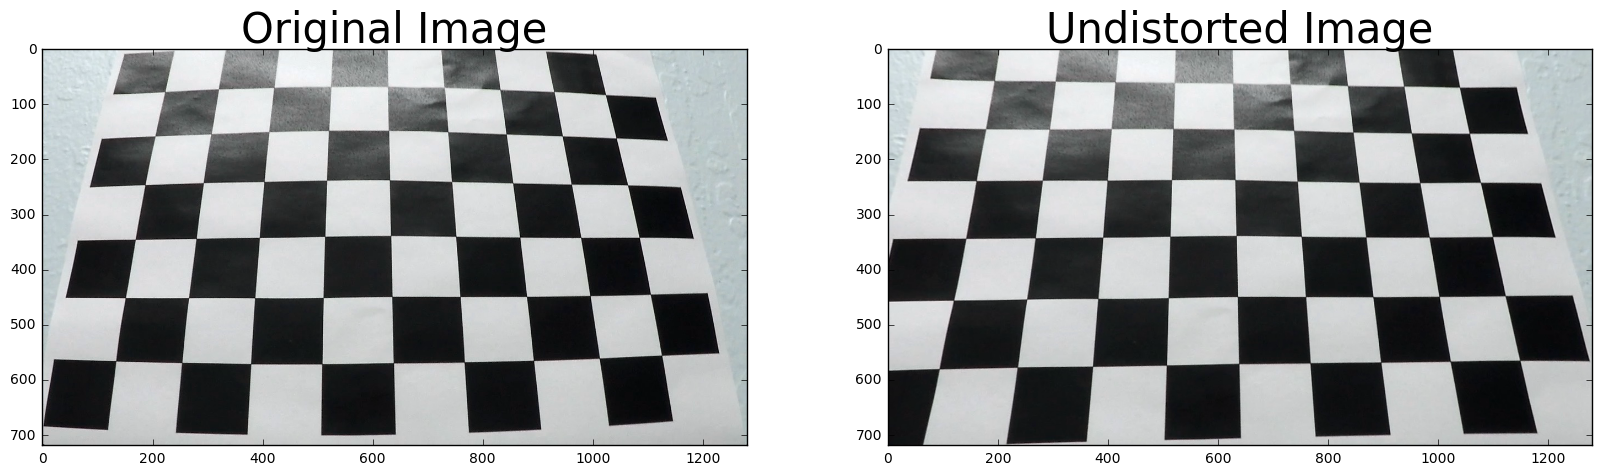

In [3]:
# Test undistortion on an image
distorted_img = cv2.imread('camera_cal/calibration3.jpg')
undistorted_img = cv2.undistort(distorted_img, mtx, dist, None, mtx)

cv2.imwrite('output_images/test_undist.jpg',undistorted_img)
cv2.imwrite('output_images/test_dist.jpg', distorted_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

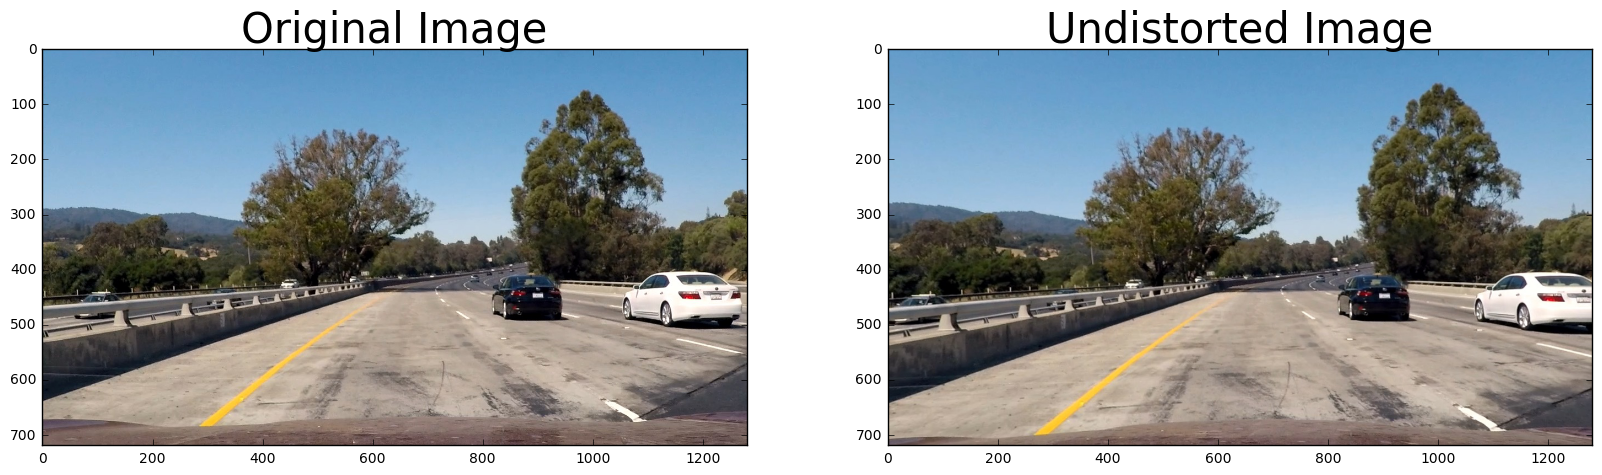

In [4]:
# Here is another example of undistortion on an image from test_images directory
distorted_img = cv2.imread('test_images/test1.jpg')
distorted_img = cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB) # convert from BGR color space tp RGB space
undistorted_img = cv2.undistort(distorted_img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('output_images/test1_dist_undist.jpg')

Implement Color and Gradient Thresholds
===

In [5]:
# Converts a grayscale image to binary image
def binary(gray_image, thresh):
    binary = np.zeros_like(gray_image)
    binary[(gray_image > thresh[0]) & (gray_image <= thresh[1])] = 1
    return binary

# Smoothes the image with a gaussian filter
def gaussian_blur(gray_image, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

# Returns a gradient in the 'x' or 'y' direction
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #blur_gray = gaussian_blur(gray, 5)
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Apply binary threshold
    binary_output = binary(scaled_sobel, thresh)
    return binary_output

# Returns the direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    # Apply binary threshold
    binary_output = binary(absgraddir, thresh)

    # Return the binary image
    return binary_output

# Returns the magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale back to 8 bit integer
    gradmag = np.uint8(255*gradmag/np.max(gradmag))

    # Apply binary threshold
    binary_output = binary(gradmag, thresh)

    # Return the binary image
    return binary_output

# Returns the color threshold an HLS color channel
def hls_color_thresh(img, color_channel='s', thresh=(0, 255)):
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Split image into H, L, S channels
    H = hls_image[:,:,0]
    L = hls_image[:,:,1]
    S = hls_image[:,:,2]

    if(color_channel == 'h'):
        channel = H
    elif(color_channel == 'l'):
        channel = L
    else:
        channel = S
        
    # Threshold color channel
    binary_output = binary(channel, thresh)
    return binary_output

# Returns the color threshold an RGB color channel
def rgb_color_thresh(img, color_channel='r', thresh=(0, 255)):

    # Split image into R, G, B channels
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]

    if(color_channel == 'r'):
        channel = R
    elif(color_channel == 'g'):
        channel = G
    else:
        channel = B
        
    # Threshold color channel
    binary_output = binary(channel, thresh)
    return binary_output

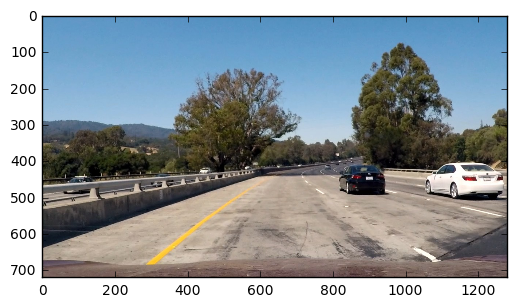

In [6]:
# Test the above thresholds with the following image
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

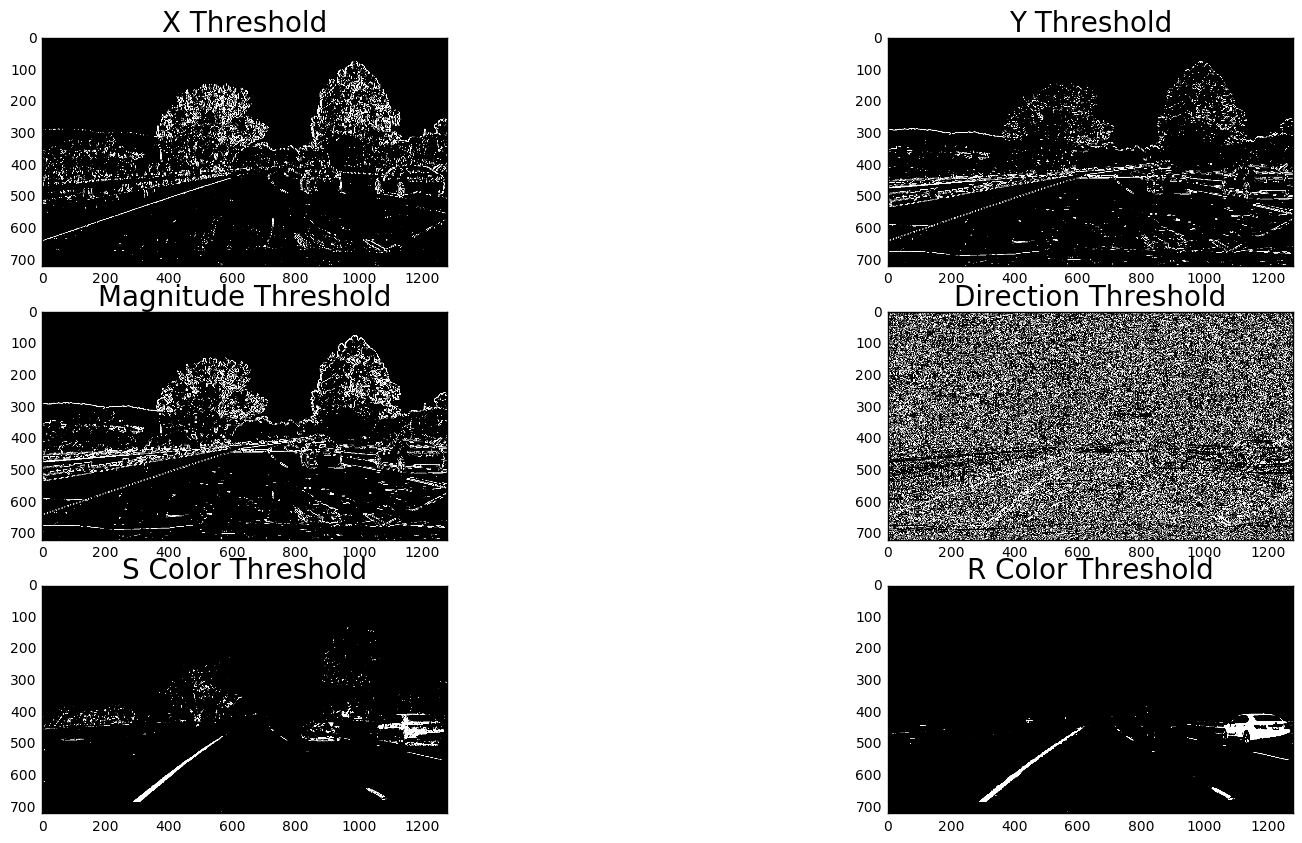

In [7]:
# Apply each of the thresholding functions to the above image and see the results below

# Choose a Sobel kernel size
ksize = 5

sxbinary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
sybinary = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 90))
mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(30, 90))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = hls_color_thresh(image, color_channel='s', thresh=(170, 255))
r_binary = rgb_color_thresh(image, color_channel='r', thresh=(220, 255))

f, (axes) = plt.subplots(3, 2, figsize=(20,10))
axes[0,0].imshow(sxbinary, cmap='gray')
axes[0,0].set_title('X Threshold', fontsize=20)
axes[0,1].imshow(sybinary, cmap='gray')
axes[0,1].set_title('Y Threshold', fontsize=20)
axes[1,0].imshow(mag_binary, cmap='gray')
axes[1,0].set_title('Magnitude Threshold', fontsize=20)
axes[1,1].imshow(dir_binary, cmap='gray')
axes[1,1].set_title('Direction Threshold', fontsize=20)
axes[2,0].imshow(s_binary, cmap='gray')
axes[2,0].set_title('S Color Threshold', fontsize=20)
axes[2,1].imshow(r_binary, cmap='gray')
axes[2,1].set_title('R Color Threshold', fontsize=20)
f.savefig('output_images/six_thresholds.jpg')

### As you notice from above thresholds the X, S, and R Thresholds provide the best edge detection. In the following we will combine these three thresholds to see if the edge detection is even sharper

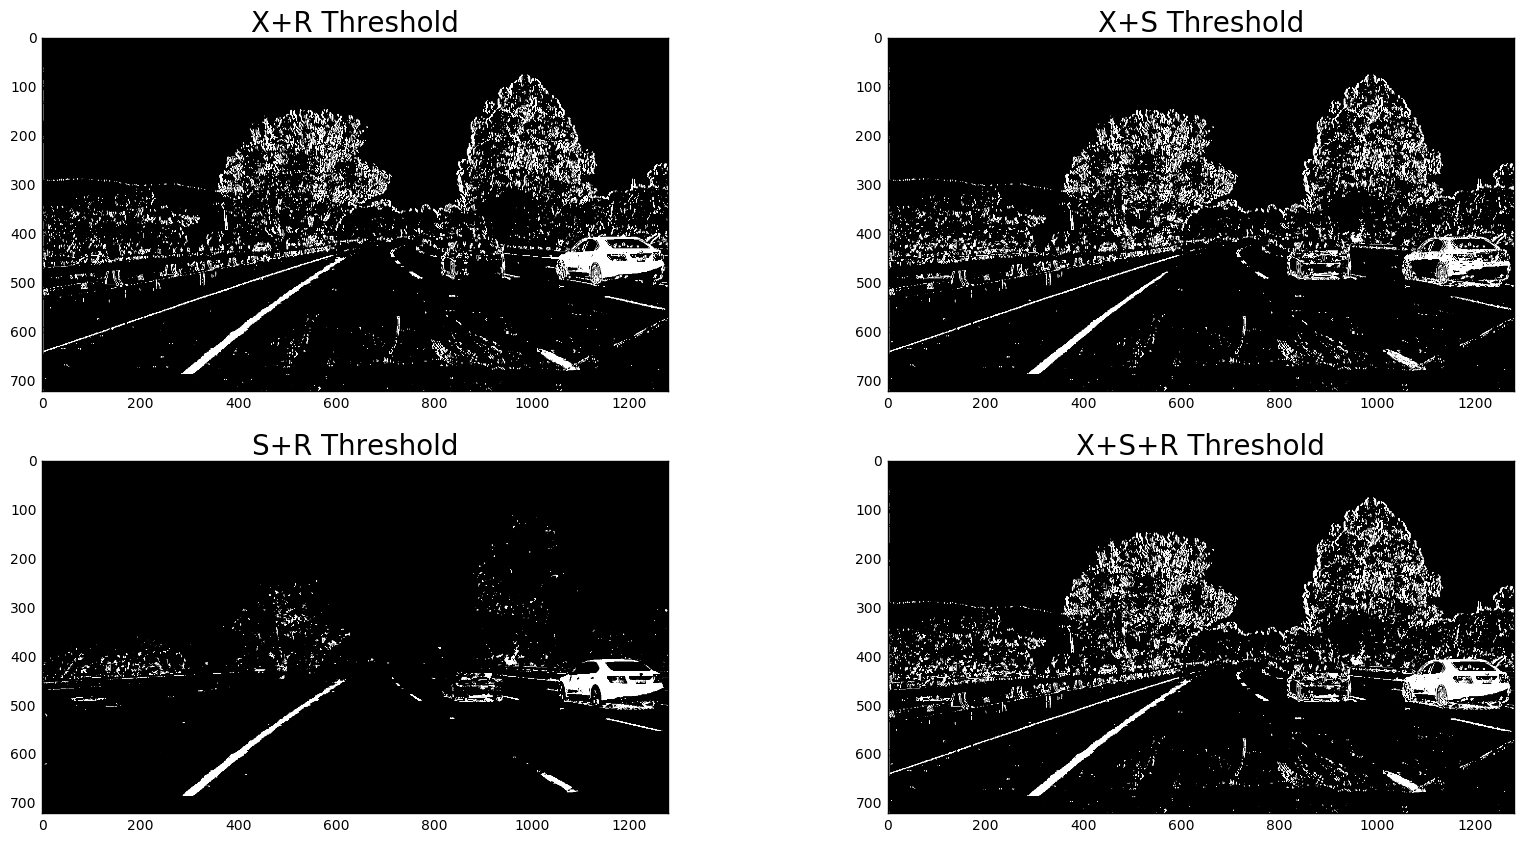

In [8]:
# Combine the binary thresholds to see output
f, (axes) = plt.subplots(2, 2, figsize=(20,10))
combined_binary = np.zeros_like(sxbinary)
combined_binary[(sxbinary == 1) | (r_binary == 1)] = 1
axes[0,0].imshow(combined_binary, cmap='gray')
axes[0,0].set_title('X+R Threshold', fontsize=20)

combined_binary = np.zeros_like(sxbinary)
combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
axes[0,1].imshow(combined_binary, cmap='gray')
axes[0,1].set_title('X+S Threshold', fontsize=20)

combined_binary = np.zeros_like(s_binary)
combined_binary[(s_binary == 1) | (r_binary == 1)] = 1
axes[1,0].imshow(combined_binary, cmap='gray')
axes[1,0].set_title('S+R Threshold', fontsize=20)


combined_binary = np.zeros_like(sxbinary)
combined_binary[(sxbinary == 1) | (s_binary == 1) | (r_binary == 1)] = 1
axes[1,1].imshow(combined_binary, cmap='gray')
axes[1,1].set_title('X+S+R Threshold', fontsize=20)


### Various combinations are shown above. I've used each of them in the video pipeline and I got the best results by combining all three thresolds (X+S+R)

Warp the Image using Perspective Transform
===

In [9]:
# M and Minv are perspective transform matrices used elsewhere
src = np.float32([[345, 670], [570,480], [755,480], [1100, 670]]) # Manually selected
dst = np.float32([[345, 720], [345, 0], [1100, 0], [1100, 720]]) # Manually selected

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the given image
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return (warped)

Detect Lane Lines and Fit a Polynomial
===

In [10]:
# Detect lanes through histogram and fit a polynomial to the lanes
def initial_lane_polynomials(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
 
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (left_fit, right_fit, out_img)

In [11]:
# Once the initial polynomial is found by the above window-sliding method, we use highly target search around the
# found polynomials within a margin for the next frame of the video
def subsequent_lane_polynomials(binary_warped, left_fit, right_fit):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (left_fit, right_fit, out_img)

Sanity check function to make sure the lane lines are roughly parallel
===

In [12]:
# Does sanity check if lines are roughly parallel
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lanesto make sure they are parallel
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
    else:
        lane_width_top = lane_width(left_fit, right_fit, 0)
        lane_width_mid = lane_width(left_fit, right_fit, 360)
        lane_width_bot = lane_width(left_fit, right_fit, 720)
        
        if (abs(lane_width_top - lane_width_bot) <= 0.4):
            status = True
        else:
            status = False
               
    return(status)

Functions to find radius of the lane lines, offset of the center of the car from the center of the lanes, and lane width
===

In [13]:
# Radius of the curvature is required to determine the suitable driving speed for the vehicle
# The radius calculations are in meters
def radius_of_curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (int(left_curverad), int(right_curverad))

In [14]:
# Measure the offset of the center of the car to the center of the lane in meters
def lane_offset(left_fit, right_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    mid_point_of_lane = ((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]))/2 
    mid_point_of_car = 1280/2
    return (mid_point_of_lane - mid_point_of_car) * xm_per_pix

In [15]:
# Measure the lane width at a certain 'y' point in meters
def lane_width(left_fit, right_fit, y_val):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    width = (right_fit[0]*y_val**2+right_fit[1]*y_val+right_fit[2]) - (left_fit[0]*y_val**2+left_fit[1]*y_val+left_fit[2])
    return width * xm_per_pix

Drawing functions to draw the final lane lines on the original image and to draw text on the final image
===

In [16]:
# Once we find good lines we draw the lines on the original image
def draw_lanes(undist, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return(result)

In [17]:
# Write curvature radii and lane offset on the final image
def draw_text(final_img, left_radius, right_radius, offset):
    left_radius_txt = "Left radius: " + str(left_radius) + "m"
    right_radius_txt = "Right radius: " + str(right_radius)+ "m"
    lane_offset_txt = "Lane offset: " + str(round(offset,2)) + "m"
    
    fontScale=1
    thickness=2
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    cv2.putText(final_img, left_radius_txt, (80,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(final_img, right_radius_txt, (80,80), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(final_img, lane_offset_txt, (80,120), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    return(final_img)

Pipeline for Processing an Image
===

In [18]:
# Image processing pipeline
# Takes an image, detects the lane lines using a combined X, S, and R thresholds, warps the image to get a birds eye view 
# perspective, detects the lane lines and fits a polynomial to the lines, warps the lines back onto the original image
def process_image(img, visualization = 0): # If visualization is set to one plot the images
    global left_fit, right_fit, rel_left_fit, rel_right_fit, frame_counter, false_counter

    # Read in the image from a file or an array
    if (type(img).__module__ == np.__name__):
        image = img
    else:
        image = mpimg.imread(img)
      
    # Undistort the original image with the camera matrix and distortion coefficients
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Apply a combined threshold of X, S and R
    ksize = 3
    sxbinary = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    s_binary = hls_color_thresh(image, color_channel='s', thresh=(170, 255))
    r_binary = rgb_color_thresh(image, color_channel='r', thresh=(220, 255))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1) | (r_binary == 1)] = 1
       
    # Warp the undistorted binary image to get a bird's eye view of the road    
    warped = warp(combined_binary)
    
    if(visualization == 1): 
        f, (axes) = plt.subplots(2, 2, figsize=(20,10))
        
        # Original image with a trapezoid
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        src1 = np.int32([src])
        cv2.polylines(out_img, src1, 1, (0,0,255), 3)
        axes[0,0].imshow(out_img, cmap='gray')
        axes[0,0].set_title('Original image', fontsize=20)

        # Warped image with a rectangle
        out_img = np.dstack((warped, warped, warped))*255
        dst1 = np.int32(dst)
        cv2.rectangle(out_img, tuple(map(tuple, dst1))[0], tuple(map(tuple, dst1))[2], (255,0,0), 3)
        axes[0,1].imshow(out_img, cmap='gray')
        axes[0,1].set_title('Warped image', fontsize=20)
       
    # This is the main algorithm where the lanes are found and polynomials are fit
    if(frame_counter == 0):
        left_fit, right_fit, out_img = initial_lane_polynomials(warped)
        if(visualization == 1):
            # Generate x and y values for plotting
            ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            axes[1,0].imshow(out_img, cmap='gray')
            axes[1,0].imshow(out_img)
            axes[1,0].plot(left_fitx, ploty, color='yellow')
            axes[1,0].plot(right_fitx, ploty, color='yellow')
            axes[1,0].set_xlim(0, 1280)
            axes[1,0].set_ylim(720, 0)

            axes[1,0].set_title('Initial Line Fitting', fontsize=20)
    else:
        left_fit, right_fit, out_img = subsequent_lane_polynomials(warped, left_fit, right_fit)
        if(visualization == 1):
            # Generate x and y values for plotting
            ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            margin = 100    
            
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            window_img = np.zeros_like(out_img)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

            axes[1,0].imshow(result)
            axes[1,0].plot(left_fitx, ploty, color='yellow')
            axes[1,0].plot(right_fitx, ploty, color='yellow')
            axes[1,0].set_xlim(0, 1280)
            axes[1,0].set_ylim(720, 0)

            axes[1,0].set_title('Subsequent Line Fitting', fontsize=20)

    # Sanity check to see if the fit makes sense
    # If status is true, we got a good fit so we use the found polynomials.
    # If status is false, we did not get good polynomials. After five continuous bad polynomials I go back to
    # the window-sliding method to search for a new polynomial
    sanity_status = sanity_check(left_fit, right_fit)
    if (sanity_status == True):
        rel_left_fit = left_fit
        rel_right_fit = right_fit
        frame_counter = 1
        false_counter = 0
    else:
        false_counter += 1
        if ((frame_counter == 0) & (sum(rel_left_fit) == 0)):
            rel_left_fit = left_fit
            rel_right_fit = right_fit
        else:
            left_fit = rel_left_fit
            right_fit = rel_right_fit
            frame_counter = 1
            if (false_counter > 5):
                frame_counter = 0 # Start window sliding again
                false_counter = 0

    # Radius calculations are required to determine the speed of the vehicle
    left_radius, right_radius = radius_of_curvature(left_fit, right_fit, warped)

    # Lane offset calculations tell us how far away the vehicle is from the center of the lane
    offset = lane_offset(left_fit, right_fit)
 
    # Draw lanes and text on the final image
    result = draw_lanes(undist, warped, left_fit, right_fit)
    result = draw_text(result, left_radius, right_radius, offset)
    
    if(visualization == 1):
        axes[1,1].imshow(result)
        axes[1,1].set_title('Final image', fontsize=20)
        axes[1,1].set_xlim(0, 1280)
        axes[1,1].set_ylim(720, 0)
    
    return result

## Image Processing

In [19]:
left_fit = [0,0,0]
right_fit = [0,0,0]
rel_left_fit = [0,0,0]
rel_right_fit = [0,0,0]
frame_counter = 0
false_counter = 0

In [20]:
import os
image_file_list = os.listdir("test_images/")
print("image files", image_file_list)

image files ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


In [21]:
#fnl_img = process_image('test_images/test6.jpg', 0)
#plt.imshow(fnl_img)

In [22]:
for image_file in image_file_list:
    image_file_and_dir = "test_images/"+image_file
    print("Input image files", image_file_and_dir)
    output_file = "output_images/"+os.path.splitext(image_file)[0]+"_output.jpg"
    print("Output image files", output_file)
    fnl = process_image(image_file_and_dir)
    mpimg.imsave(output_file, fnl)

Input image files test_images/straight_lines1.jpg
Output image files output_images/straight_lines1_output.jpg


C:\Users\Kris\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Input image files test_images/straight_lines2.jpg
Output image files output_images/straight_lines2_output.jpg
Input image files test_images/test1.jpg
Output image files output_images/test1_output.jpg
Input image files test_images/test2.jpg
Output image files output_images/test2_output.jpg
Input image files test_images/test3.jpg
Output image files output_images/test3_output.jpg
Input image files test_images/test4.jpg
Output image files output_images/test4_output.jpg
Input image files test_images/test5.jpg
Output image files output_images/test5_output.jpg
Input image files test_images/test6.jpg
Output image files output_images/test6_output.jpg


## Video Processing

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
left_fit = [0,0,0]
right_fit = [0,0,0]
rel_left_fit = [0,0,0]
rel_right_fit = [0,0,0]
frame_counter = 0
false_counter = 0

output = 'ProjVideoOut.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ProjVideoOut.mp4
[MoviePy] Writing video ProjVideoOut.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:02<00:00,  5.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ProjVideoOut.mp4 

Wall time: 4min 4s
